In [1]:
# -*- coding: utf-8 -*-
# -*- author : Vincent Roduit - Fabio Palmisano -*-
# -*- date : 2024-01-20 -*-
# -*- Last revision: 2024-01-20 (Vincent Roduit)-*-
# -*- python version : 3.11.6 -*-
# -*- Description: Notebook that summarizes results-*-

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/EE-411-FOIL-Project/source

/content/drive/MyDrive/EE-411-FOIL-Project/source


# <center> EE - 411: Fundamentals of Inference and Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Deep Double Descent: When Bigger Models and More Data Hurt </center>
---

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Import librairies
import torch
import torchvision
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import copy

In [6]:
# Import files
import constants
from models.resnet18k import make_resnet18k
from models.mcnn import make_cnn
from training_utils import*

# 1. Data preprocessing

## 1.1 Load data

### 1.1.1 Normal version

#### MNIST

In [7]:
transform = transforms.Compose([
    transforms.ToTensor()
])
# -*- LOAD MNIST -*-

#Train Dataset
MNIST_train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

#Test Dataset
MNIST_test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

#### CIFAR 10

In [8]:
transform = transforms.Compose([
    transforms.ToTensor()
])
# -*- LOAD CIFAR 10 -*-

#Train Dataset
CIFAR_10_train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

#Test Dataset
CIFAR_10_test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

# -*- LOAD CIFAR 100 -*-

#Train Dataset
CIFAR_100_train_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

#Test Dataset
CIFAR_100_test_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### 1.1.2. Augmented version

In [9]:
transform_augmented = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
# -*- LOAD MNIST -*-

#Train Dataset
MNIST_train_dataset_aug = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform_augmented)

#Test Dataset
MNIST_test_dataset_aug = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform_augmented)

In [10]:
transform_augmented = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# -*- LOAD CIFAR 10 -*-

#Train Dataset
CIFAR_10_train_dataset_aug = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform_augmented)

#Test Dataset
CIFAR_10_test_dataset_aug = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform_augmented)

# -*- LOAD CIFAR 100 -*-

#Train Dataset
CIFAR_100_train_dataset_aug = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=transform_augmented)

#Test Dataset
CIFAR_100_test_dataset_aug = torchvision.datasets.CIFAR100(
    root='./data/',
    train=False,
    download=True,
    transform=transform_augmented)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## 1.2 Create Dataloader

### 1.2.1 Normal version

In [11]:
CIFAR_10_train_dataloader = torch.utils.data.DataLoader(
    dataset=CIFAR_10_train_dataset,
    batch_size=constants.BATCH_SIZE,
    shuffle=True,
    num_workers=2)


# Construct the dataloader for the testing dataset.
CIFAR_10_test_dataloader = torch.utils.data.DataLoader(
    dataset=CIFAR_10_test_dataset,
    batch_size=constants.TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

CIFAR_100_train_dataloader = torch.utils.data.DataLoader(
    dataset=CIFAR_100_train_dataset,
    batch_size=constants.BATCH_SIZE,
    shuffle=True,
    num_workers=2)


# Construct the dataloader for the testing dataset.
CIFAR_100_test_dataloader = torch.utils.data.DataLoader(
    dataset=CIFAR_100_test_dataset,
    batch_size=constants.TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

### 1.2.2 Augmented version

In [12]:
def label_noise(dataset, noise_ratio=0.1, seed = 0):
    np.random.seed(seed)

    # Make a deep copy of the dataset
    noisy_dataset = copy.deepcopy(dataset)

    total_images = len(noisy_dataset)

    num_noisy_images = int(total_images * noise_ratio)

    indices = np.random.choice(total_images, num_noisy_images, replace=False)

    num_classes = len(np.unique(noisy_dataset.targets))

    for idx in indices:
        noisy_dataset.targets[idx] = torch.randint(0, num_classes, (1,))

    return noisy_dataset

## 1.3 Vizualize the Dataset

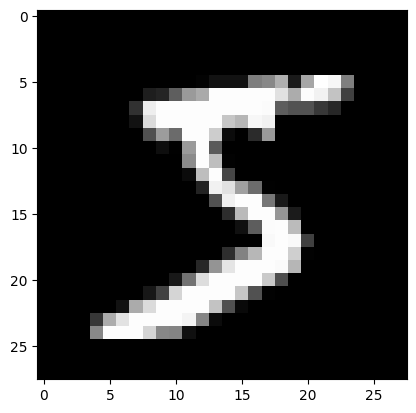

In [13]:
images = next(iter(MNIST_train_dataset))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

# 2. Produce Figure 4

## 2.1 MNIST

In [ ]:
width_model_list = np.linspace(1, 64, 20,dtype=int)
noise_ratio_list = [0,0.1,0.2]

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

subsample_train_indices = torch.randperm(len(MNIST_train_dataset_aug))[:constants.NUM_SAMPLES]

for noise_ratio in noise_ratio_list:
    noise_train_loss = []
    noise_train_acc = []
    noise_test_loss = []
    noise_test_acc = []
    print(f'Predicting with noise ratio {noise_ratio}')
    noisy_train_dataset = label_noise(MNIST_train_dataset_aug, noise_ratio=noise_ratio)
    noisy_train_dataloader = torch.utils.data.DataLoader(
        dataset=noisy_train_dataset,
        batch_size=constants.BATCH_SIZE,
        sampler=SubsetRandomSampler(subsample_train_indices),
        num_workers=2)
    noisy_test_dataset = label_noise(MNIST_test_dataset_aug, noise_ratio=noise_ratio)
    noisy_test_dataloader = torch.utils.data.DataLoader(
        dataset=noisy_test_dataset,
        batch_size=constants.TEST_BATCH_SIZE,
        shuffle=False,
        num_workers=2)

    for width in width_model_list:
        #print(f'Predicting with width {width}')
        ResNet = make_resnet18k(k=width)
        cnn = ResNet.to(constants.DEVICE)
        optimizer = torch.optim.Adam(cnn.parameters(), lr=constants.Adam_LR)
        losses = fit(
            model=cnn,
            train_dataloader=noisy_train_dataloader,
            optimizer=optimizer,
            epochs=50,
            device=constants.DEVICE
        )
        train_loss, acc_train = predict(model=cnn, test_dataloader=noisy_train_dataloader, device=constants.DEVICE)
        test_loss, acc = predict(model=cnn, test_dataloader=noisy_test_dataloader, device=constants.DEVICE)

        noise_train_loss.append(train_loss)
        noise_train_acc.append(acc_train)

        noise_test_loss.append(test_loss)
        noise_test_acc.append(acc)
        print(width)
    train_losses.append(noise_train_loss)
    train_accuracies.append(noise_train_acc)
    test_losses.append(noise_test_loss)
    test_accuracies.append(noise_test_acc)

Predicting with noise ratio 0
1
4


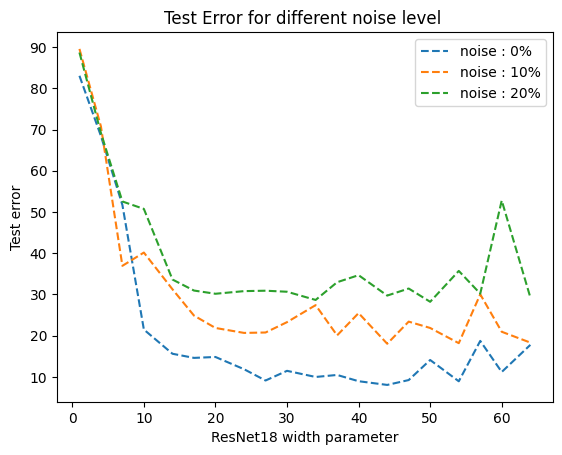

In [ ]:
for noise_level, noise_curve in enumerate(test_accuracies):
  acc = np.array([i.item() for i in noise_curve])
  test_error = 100 - acc
  plt.plot(width_model_list, test_error, '--',label = f'noise : {int(noise_ratio_list[noise_level]*100)}%')
plt.legend()
plt.xlabel('ResNet18 width parameter')
plt.ylabel('Test error')
plt.title('Test Error for different noise level ')
plt.show()

In [ ]:
for noise_level, noise_curve in enumerate(train_accuracies):
  acc = np.array([i.item() for i in noise_curve])
  test_error = 100 - acc
  plt.plot(width_model_list, test_error, '--',label = f'noise : {int(noise_ratio_list[noise_level]*100)}%')
plt.legend()
plt.xlabel('ResNet18 width parameter')
plt.ylabel('Train error')
plt.title('Train Error for different noise level ')
plt.show()


In [ ]:
width_model_list = np.linspace(1, 64, 20,dtype=int)
noise_ratio_list = [0,0.1,0.2]

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

subsample_train_indices = torch.randperm(len(MNIST_train_dataset_aug))[:constants.NUM_SAMPLES]

for noise_ratio in noise_ratio_list:
    noise_train_loss = []
    noise_train_acc = []
    noise_test_loss = []
    noise_test_acc = []
    print(f'Predicting with noise ratio {noise_ratio}')
    noisy_train_dataset = label_noise(MNIST_train_dataset_aug, noise_ratio=noise_ratio)
    noisy_train_dataloader = torch.utils.data.DataLoader(
        dataset=noisy_train_dataset,
        batch_size=constants.BATCH_SIZE,
        sampler=SubsetRandomSampler(subsample_train_indices),
        num_workers=2)
    noisy_test_dataset = label_noise(MNIST_test_dataset_aug, noise_ratio=noise_ratio)
    noisy_test_dataloader = torch.utils.data.DataLoader(
        dataset=noisy_test_dataset,
        batch_size=constants.TEST_BATCH_SIZE,
        shuffle=False,
        num_workers=2)

    for width in width_model_list:
        #print(f'Predicting with width {width}')
        ResNet = make_resnet18k(k=width)
        cnn = ResNet.to(constants.DEVICE)
        optimizer = torch.optim.Adam(cnn.parameters(), lr=constants.Adam_LR)
        losses = fit(
            model=cnn,
            train_dataloader=noisy_train_dataloader,
            optimizer=optimizer,
            epochs=20,
            device=constants.DEVICE
        )
        train_loss, acc_train = predict(model=cnn, test_dataloader=noisy_train_dataloader, device=constants.DEVICE)
        test_loss, acc = predict(model=cnn, test_dataloader=noisy_test_dataloader, device=constants.DEVICE)

        noise_train_loss.append(train_loss)
        noise_train_acc.append(acc_train)

        noise_test_loss.append(test_loss)
        noise_test_acc.append(acc)
        print(width)
    train_losses.append(noise_train_loss)
    train_accuracies.append(noise_train_acc)
    test_losses.append(noise_test_loss)
    test_accuracies.append(noise_test_acc)

Predicting with noise ratio 0
1
4
7
10
14
17
20
24
27
30
34
37
40
44
47
50
54
57
60
64
Predicting with noise ratio 0.1
1
4
7
10
14
17
20
24
27
30
34
37
40
44
47
50
54
57
60
64
Predicting with noise ratio 0.2
1
4
7
10
14
17
20
24
27
30
34
37
40
44
47
50
54
57
60
64


## Figure 6 : SGD vs Adam
5 Layer CNNs on CIFAR 10, no label noise, no data augmentation, using SGD for 500k gradient step, adam for 4K epochs

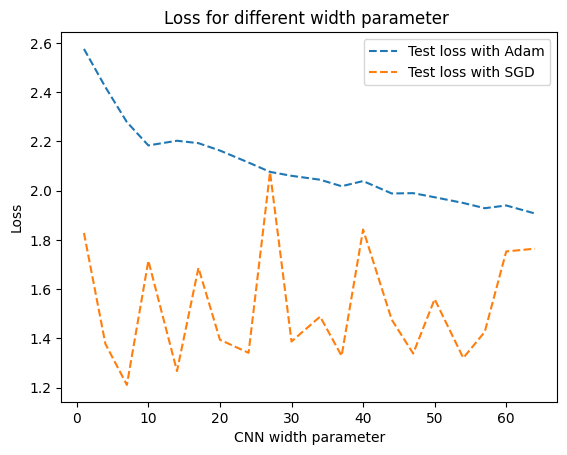

In [14]:
width_model_list = np.linspace(1, 64, 20,dtype=int)


train_losses_Adam = []
train_accuracies_Adam = []
test_losses_Adam = []
test_accuracies_Adam = []

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

subsample_train_indices = torch.randperm(len(CIFAR_10_train_dataset))[:constants.NUM_SAMPLES]

for width in width_model_list :
    cnn_model = make_cnn(c = width)
    cnn = cnn_model.to(constants.DEVICE)
    optimizer_Adam = torch.optim.SGD(cnn.parameters(), lr=constants.Adam_LR)
    losses_Adam = fit(
        model=cnn,
        train_dataloader=CIFAR_10_train_dataloader,
        optimizer=optimizer_Adam,
        epochs=2,
        device=constants.DEVICE
    )
    train_loss_Adam, acc_train_Adam = predict(model=cnn, test_dataloader=CIFAR_10_train_dataloader, device=constants.DEVICE)
    test_loss_Adam, acc_Adam = predict(model=cnn, test_dataloader=CIFAR_10_test_dataloader, device=constants.DEVICE)

    train_losses_Adam.append(train_loss_Adam)
    train_accuracies_Adam.append(acc_train_Adam)

    test_losses_Adam.append(test_loss_Adam)
    test_accuracies_Adam.append(acc_Adam)


    optimizer_SGD = torch.optim.SGD(cnn.parameters(), lr=constants.SGD_LR)
    losses_SGD = fit(
        model=cnn,
        train_dataloader=CIFAR_10_train_dataloader,
        optimizer=optimizer_SGD,
        epochs=2,
        device=constants.DEVICE
    )
    train_loss, acc_train = predict(model=cnn, test_dataloader=CIFAR_10_train_dataloader, device=constants.DEVICE)
    test_loss, acc = predict(model=cnn, test_dataloader=CIFAR_10_test_dataloader, device=constants.DEVICE)

    train_losses.append(train_loss)
    train_accuracies.append(acc_train)

    test_losses.append(test_loss)
    test_accuracies.append(acc)


plt.plot(width_model_list, test_losses_Adam, '--',label = 'Test loss with Adam')
plt.plot(width_model_list, test_losses, '--',label = 'Test loss with SGD')
plt.legend()
plt.xlabel('CNN width parameter')
plt.ylabel('Loss')
plt.title('Loss for different width parameter ')
plt.show()